# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained ViT image encoder from META's Segment Anything Model SAM
We explore a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Skip Connection MLP
4. Spatially Aware MLP




---
### Loss function: 
We use combination of the following: 
- DiceLoss
- FocalLoss
- BCEWithLogitsLoss


In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###### KAGGLE DATA SET #####
kaggle_data = {}
kaggle_data["images"] =load_training_images()
kaggle_data["masks"] = load_groundtruth_images()

######## EPFL DATA SET #####
epfl_data = {}
epfl_data["images"] = load_training_images("EPFL")
epfl_data["masks"] = load_groundtruth_images("EPFL")


####### CUSTOM GOOGLE MAPS DATA SET #####
city_names = ["boston","nyc","philadelphia","austin"]
gmaps_data = {"images":[],"masks":[]} # stores images and gt masks
for name in city_names:
    gmaps_data["images"].extend(load_training_images(name))
    gmaps_data["masks"].extend(load_groundtruth_images(name))
assert (len(gmaps_data["images"]) == len(gmaps_data["masks"]))



######## PRINT GOOGLE MAPS DS STATISTICS ########
print("the raw custom dataset contains",len(gmaps_data["images"]),"images")
print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(gmaps_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(kaggle_data["masks"]))
print("custom ds with ignore under threshold: (min,mean,max) street ratio",get_street_ratio_mmm(gmaps_data["masks"],min_ratio_threshold=0.03))



##############
gmaps_data_set = Sat_Mask_Dataset(gmaps_data["images"], gmaps_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
kaggle_data_set  = Sat_Mask_Dataset(kaggle_data["images"],kaggle_data["masks"])
epfl_data_set = Sat_Mask_Dataset(epfl_data["images"],epfl_data["masks"])

print("after cleanup, the dataset now contains",len(kaggle_data_set),"images")


######## KAGGLE - SUBMISSION DATA SET ########
kaggle_submission_images = load_test_images()
kaggle_submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)



# print num of data in original and custom dataset
print("original dataset contains",len(gmaps_data_set),"images")
print("custom dataset contains",len(kaggle_data_set),"images")


using device: cuda:0
the raw custom dataset contains 12985 images
custom ds: (min,mean,max) street ratio (0.0, 0.13372669666923362, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.177976953125, 0.40426875)
custom ds with ignore under threshold: (min,mean,max) street ratio (0.03005625, 0.14823332153582142, 0.72180625)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.10242587601078167  num discarded: 1330
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 144 images
original dataset contains 11655 images
custom dataset contains 144 images


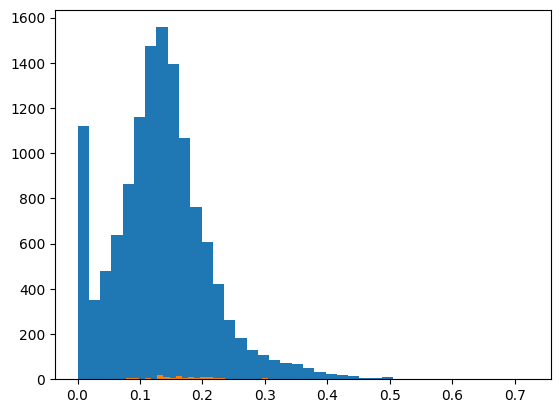

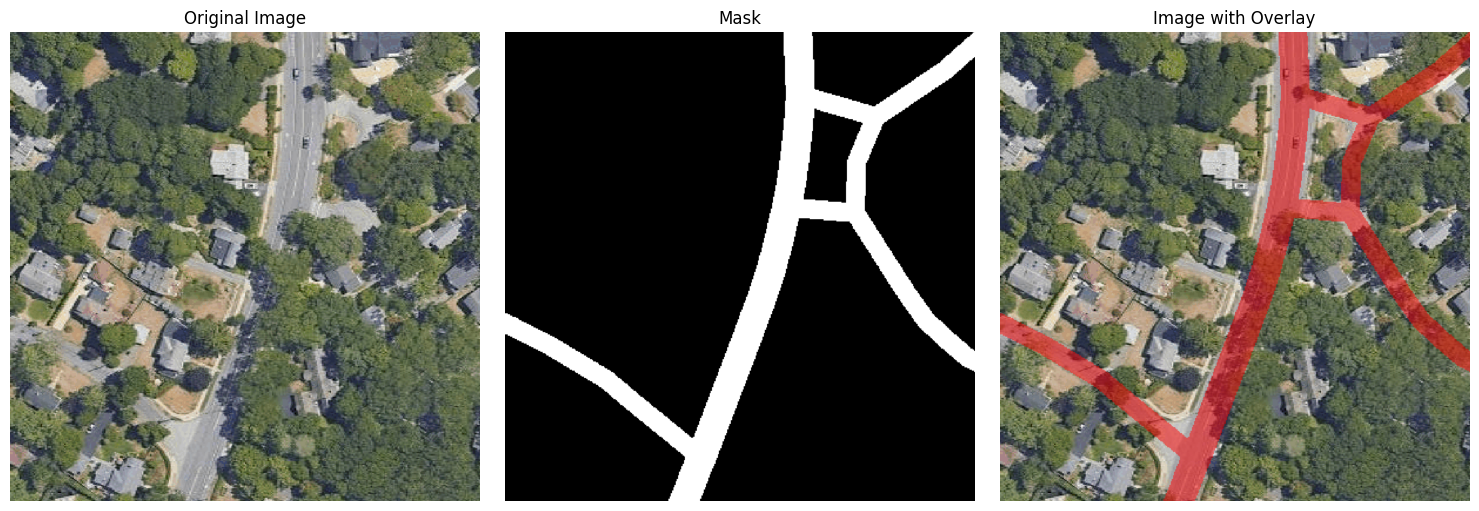

In [4]:
show_sample_images = True
import numpy as np
import matplotlib.pyplot as plt

if show_sample_images:
    
    ######### show distribution of street ratio:
    
    # plot the street ratio distribution of the dataset

    custom_ratios = get_street_ratio_distr(gmaps_data["masks"])
    original_ratios = get_street_ratio_distr(kaggle_data["masks"])

    plt.hist(custom_ratios,40)
    plt.hist(original_ratios,40)
    plt.show()
    
    # get some random training images
    idx = 4
    image, mask = kaggle_data_set[idx]

    img = np.array(image).astype(np.uint8)
    # swap first and third dimension
    img = np.swapaxes(img, 0, 2)
    mask = np.array(mask)
    mask = np.swapaxes(mask, 0, 2)

    # Create a reddish tone image with the same shape as the original image
    reddish_tone = np.zeros_like(img)
    reddish_tone[..., 0] = 255  # Red channel to maximum

    # Define the opacity for the overlay
    opacity = 0.5

    # Ensure the mask is binary (0 or 255) and has the same shape as the original image
    binary_mask = (mask > 0).astype(np.uint8) * 255

    # Blend the original image and the reddish tone based on the mask
    blended_image = np.where(binary_mask == 255, 
                            (img * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                            img)

    # Display the original image, mask, and blended image side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(blended_image)
    axes[2].set_title('Image with Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


## Dataloader

In [3]:
train_split = 0.8


gpu_batch_size = 1

import torch.utils.data

torch.manual_seed(0)
gen = torch.Generator()
gen.manual_seed(0)


kaggle_train_dataset, kaggle_test_dataset = torch.utils.data.random_split(kaggle_data_set, [train_split, 1-train_split],generator=gen)
gmaps_train_dataset, gmaps_test_dataset = torch.utils.data.random_split(gmaps_data_set, [train_split, 1-train_split],generator=gen)


# combine kaggle and epfl data set
kaggle_epfl_dataset = torch.utils.data.ConcatDataset([kaggle_data_set,epfl_data_set])
# split the combined dataset into train and test set
kaggle_epfl_train_dataset, kaggle_epfl_test_dataset = torch.utils.data.random_split(kaggle_epfl_dataset, [train_split, 1-train_split],generator=gen)


from torch.utils.data import DataLoader
#gmaps_train_dataloader = DataLoader(gmaps_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#gmaps_test_dataloader = DataLoader(gmaps_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
gmaps_dataloader = DataLoader(gmaps_data_set, batch_size=1, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# kaggle dataloader
kaggle_dataloader = DataLoader(kaggle_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
kaggle_train_dataloader = DataLoader(kaggle_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
kaggle_test_dataloader = DataLoader(kaggle_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# kaggel_epfl dataloader
kaggle_epfl_train_dataloader = DataLoader(kaggle_epfl_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
kaggle_epfl_test_dataloader = DataLoader(kaggle_epfl_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)


# dataloader for submission dataset: 
submission_dataloader = DataLoader(kaggle_submission_data_set, batch_size=1, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)



## Loading the model

In [4]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(encoder_option:int, device,decoder):
    #
    # encoder_option =0 : for vit_b with the encoder that just retunrs the final block output.
    # encoder_option =1 : for vit_b with the encoder that returns the intermediate outputs + final output.  

    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_b_intermediate"]#,"vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth"] #,"sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[encoder_option]](checkpoint=model_paths[0])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_first_layers,encoder_finetune_num_last_layers,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam",load_from_compiled=False):
    #   
    #   decoder_options: ["conv", "mlp" , "spatial-full", "spatial-small", "skip-connect]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #

    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-full":
        decoder = MLP_Decoder_Spatially_Aware(context_option=1)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-small":
        decoder = MLP_Decoder_Spatially_Aware(context_option=0)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    elif decoder_option == "skip-connect":
        decoder = Skip_MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(1,device,decoder)
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        
        if "custom_segment_anything/model_checkpoints" in finetuned_model_name:
            load_path = finetuned_model_name+".pth"
        else:
            load_path = finetune_path+finetuned_model_name+".pth"
        if load_from_compiled:
            model = torch.compile(model)
        model.load_state_dict(torch.load(load_path,map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers or layer_number < encoder_finetune_num_first_layers:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    #model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Actually loading the model

In [10]:
"""
finetuned_model_name = "model_best_so_far.pth"

model = load_sam_model("skip-connect",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="finetuned")

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
"""

'\nfinetuned_model_name = "model_best_so_far.pth"\n\nmodel = load_sam_model("skip-connect",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="finetuned")\n\nprint("Model loaded")\n# how many trainable parameters does the model have?\nprint("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))\n# how many total parameters does the model have?\nprint("Total parameters",sum(p.numel() for p in model.parameters()))\n\n# percentage of trainable parameters\nprint("Percentage of trainable parameters: ")\nprint("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))\n'

# Loss Functions

In [5]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1


def wrong_dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = probs.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


def dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def only_bce(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    
    return bce_loss(logits_sq, mask_sq)

def combined_loss_p2_norm(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    return bce_loss(logits_sq, mask_sq) + wrong_dice_loss(logits, masks, smooth=smooth)

def combined_loss_dice(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

# Training Loop - All Decoder Variants
go over all possible decoder models

train for a few epochs with only few encoder layers unlocked until the last epoch didnt improve the original loss
increase the number of layers finetuned, 
if the whole epoch didnt improve, then stop the training in general

always store the model, start each new layer round with the best of the last or second last stored model. 


In [12]:
### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = gmaps_dataloader
test_loader = kaggle_dataloader


########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader)
20
do_intermed_prints = False

#########

decoder_options =  ["conv","spatial-small","spatial-full","skip-connect","mlp"]
num_layers_to_finetune_back = [25,65,85,105]
num_layers_to_finetune_front = [0,0,15,25]
learning_rates = [0.001,0.0001, 0.0001,0.0001]
loss_functions = [only_bce,combined_loss_p2_norm,combined_loss_dice]
max_epochs = [3,3,4,4]
grad_batch_size_choices = [5,5,5,5]

##################################
# TRAINING LOOP
################################


# OPTIMIZATIONS 
mean_f1_score_from_logits = torch.compile(mean_f1_score_from_logits)

loss_fn_idx = 2
# Hyperparameter tuning yielded that we use the loss function BCE + Dice for the best results

loss_fn = loss_functions[loss_fn_idx]
loss_fn = torch.compile(loss_fn)
print("using loss function:",loss_fn)

for decoder_option in decoder_options:
        
    for idx_layer_option in range(len(num_layers_to_finetune_back)):
        # set the max number of epochs for this layer option
        max_num_epochs = max_epochs[idx_layer_option]
        
        for epoch_counter in range(max_num_epochs):
            torch.cuda.empty_cache()
            gc.collect()

            epoch_to_train = epoch_counter
            layer_option_back = num_layers_to_finetune_back[idx_layer_option]
            layer_option_front = num_layers_to_finetune_front[idx_layer_option]
            
            # if the layer_option is larger than 1 (i.e. if at least 85 layers in the back are tuned, reduce lr.), reduce lr 
            learning_rate = learning_rates[idx_layer_option]
            if idx_layer_option >= 2:
                learning_rate = learning_rate / (epoch_counter + 1)
                print("divided lr")
            print("using lr:",learning_rate)
            #loss_fn = loss_functions[loss_fn_idx]
            #print("using loss function:",loss_fn)
            grad_batch_size = grad_batch_size_choices[loss_fn_idx]
            
            #####################################            
            # now training this model 
            current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter}"
            print("training model:",current_model_description)
            # check if this current model description already exists, if so, load the model and skip this exact training step:
            if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                print("model already exists, skipping training for this layer option")
                continue
            # since model was not already trained
            # load the "start model from checkpoint or finetuned"
            # load the initial model from the sam checkpoint
            if idx_layer_option == 0 and epoch_counter == 0:
                print("loading model from sam checkpoint")
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=None,sam_checkpoint_or_finetuned="sam",load_from_compiled=False)
                model = torch.compile(model)
            else:
                
                if epoch_counter == 0:
                    last_max_epoch = max_epochs[idx_layer_option-1]
                    # now epoch 0, hence load max epoch from previous layer option
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{num_layers_to_finetune_front[idx_layer_option-1]}_{num_layers_to_finetune_back[idx_layer_option-1]}_epoch_{last_max_epoch-1}"
                else:
                    # load the last epoch from current layer option
                    
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter-1}"
                print("loading model from finetuned:",model_description)
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
                
            # newly initializing the optimizer and scheduler since model was loaded new (do this for every epoch:)
            ####################################
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            print("Starting Epoch: ",epoch_counter)
            # training run: 
            model.train()
            # store running losses for the epoch and the 10% print interval
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0

            short_running_loss = 0.0
            short_running_f1 = 0.0

            step_counter = 0
            
            # reset the gradients: 
            optimizer.zero_grad()
            
            #########################################
            # TRAINING LOOP
            for image, mask in tqdm(train_loader):
                step_counter += 1
                #####################
                # forward pass
                image = image.to(device)
                mask = mask.to(device)    
                pred = model(image)
                # compute loss and f1 score: 
                loss = loss_fn(pred,mask)
                
                
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                short_running_loss += loss.item()
                short_running_f1 += f1_score

                loss.backward()

                ###############
                # backward pass
                if step_counter % grad_batch_size == 0:
                    # update the model weights
                    optimizer.step()
                    # reset the gradients
                    optimizer.zero_grad()
                
                if do_intermed_prints and step_counter % print_interval == 0:
                    print("step: ",step_counter//print_interval)
                    # print out the current losses:
                    print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                    # and reset the short running losses
                    short_running_loss = 0.0
                    short_running_f1 = 0.0

            print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
            ########################################
            # save the model in every epoch
            print("saving model:",current_model_description)
            torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth")
            #########################################
            
            # testing run: 
            model.eval()
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")
        # save the model after the training run

using loss function: <function combined_loss_dice at 0x7f2526d024d0>
using lr: 0.001
training model: model_3_conv_decoder_finetune_last_0_25_epoch_0
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_conv_decoder_finetune_last_0_25_epoch_1
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_conv_decoder_finetune_last_0_25_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_0_25_epoch_1
Percentage of trainable parameters:  0.14234610224075397
Starting Epoch:  2


100%|██████████| 11655/11655 [18:03<00:00, 10.76it/s]


Epoch: 2, (train) Loss: 1.5860572194577491, F1: 0.9375106460185891
saving model: model_3_conv_decoder_finetune_last_0_25_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.20it/s]


Epoch: 2, (test) Loss: 2.0560059174895287, F1-Score: 0.913624842547708
using lr: 0.0001
training model: model_3_conv_decoder_finetune_last_0_65_epoch_0
loading model from finetuned: model_3_conv_decoder_finetune_last_0_25_epoch_2
Percentage of trainable parameters:  0.35300521010298497
Starting Epoch:  0


100%|██████████| 11655/11655 [24:23<00:00,  7.96it/s]


Epoch: 0, (train) Loss: 1.449665303094251, F1: 0.942866765634536
saving model: model_3_conv_decoder_finetune_last_0_65_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.37it/s]


Epoch: 0, (test) Loss: 1.948719297018316, F1-Score: 0.917741117378076
using lr: 0.0001
training model: model_3_conv_decoder_finetune_last_0_65_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_0_65_epoch_0
Percentage of trainable parameters:  0.35300521010298497
Starting Epoch:  1


100%|██████████| 11655/11655 [24:18<00:00,  7.99it/s]


Epoch: 1, (train) Loss: 1.3578825283682125, F1: 0.9463997161168491
saving model: model_3_conv_decoder_finetune_last_0_65_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.46it/s]


Epoch: 1, (test) Loss: 1.8102088910010126, F1-Score: 0.924366613643037
using lr: 0.0001
training model: model_3_conv_decoder_finetune_last_0_65_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_0_65_epoch_1
Percentage of trainable parameters:  0.35300521010298497
Starting Epoch:  2


100%|██████████| 11655/11655 [24:20<00:00,  7.98it/s]


Epoch: 2, (train) Loss: 1.2872582562999733, F1: 0.9491560634498891
saving model: model_3_conv_decoder_finetune_last_0_65_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.56it/s]


Epoch: 2, (test) Loss: 1.8027629148628976, F1-Score: 0.9251709191335572
divided lr
using lr: 0.0001
training model: model_3_conv_decoder_finetune_last_15_85_epoch_0
loading model from finetuned: model_3_conv_decoder_finetune_last_0_65_epoch_2
Percentage of trainable parameters:  0.559055504426283
Starting Epoch:  0


100%|██████████| 11655/11655 [35:36<00:00,  5.46it/s]


Epoch: 0, (train) Loss: 1.275066633869629, F1: 0.9495999633268654
saving model: model_3_conv_decoder_finetune_last_15_85_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.50it/s]


Epoch: 0, (test) Loss: 1.7919577215280797, F1-Score: 0.925966217286057
divided lr
using lr: 5e-05
training model: model_3_conv_decoder_finetune_last_15_85_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_15_85_epoch_0
Percentage of trainable parameters:  0.559055504426283
Starting Epoch:  1


100%|██████████| 11655/11655 [35:34<00:00,  5.46it/s]


Epoch: 1, (train) Loss: 1.1661022745069645, F1: 0.9538991701086413
saving model: model_3_conv_decoder_finetune_last_15_85_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.55it/s]


Epoch: 1, (test) Loss: 1.671861778323849, F1-Score: 0.929755280415217
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_conv_decoder_finetune_last_15_85_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_15_85_epoch_1
Percentage of trainable parameters:  0.559055504426283
Starting Epoch:  2


100%|██████████| 11655/11655 [35:39<00:00,  5.45it/s]


Epoch: 2, (train) Loss: 1.1041277699552856, F1: 0.9563281637667996
saving model: model_3_conv_decoder_finetune_last_15_85_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.47it/s]


Epoch: 2, (test) Loss: 1.664580267129673, F1-Score: 0.9304674917625056
divided lr
using lr: 2.5e-05
training model: model_3_conv_decoder_finetune_last_15_85_epoch_3
loading model from finetuned: model_3_conv_decoder_finetune_last_15_85_epoch_2
Percentage of trainable parameters:  0.559055504426283
Starting Epoch:  3


100%|██████████| 11655/11655 [35:36<00:00,  5.46it/s]


Epoch: 3, (train) Loss: 1.0622598041361977, F1: 0.9580110779395691
saving model: model_3_conv_decoder_finetune_last_15_85_epoch_3


100%|██████████| 144/144 [00:18<00:00,  7.63it/s]


Epoch: 3, (test) Loss: 1.6831863921963506, F1-Score: 0.9309409939580493
divided lr
using lr: 0.0001
training model: model_3_conv_decoder_finetune_last_25_105_epoch_0
loading model from finetuned: model_3_conv_decoder_finetune_last_15_85_epoch_3
Percentage of trainable parameters:  0.710502399520313
Starting Epoch:  0


100%|██████████| 11655/11655 [37:02<00:00,  5.24it/s]


Epoch: 0, (train) Loss: 1.1706172818369949, F1: 0.9537040999650649
saving model: model_3_conv_decoder_finetune_last_25_105_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.45it/s]


Epoch: 0, (test) Loss: 1.7259286406139533, F1-Score: 0.9284691595368915
divided lr
using lr: 5e-05
training model: model_3_conv_decoder_finetune_last_25_105_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_25_105_epoch_0
Percentage of trainable parameters:  0.710502399520313
Starting Epoch:  1


100%|██████████| 11655/11655 [37:05<00:00,  5.24it/s]


Epoch: 1, (train) Loss: 1.0740386708541676, F1: 0.9575708374144539
saving model: model_3_conv_decoder_finetune_last_25_105_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.52it/s]


Epoch: 1, (test) Loss: 1.642110839072201, F1-Score: 0.9326856860684024
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_conv_decoder_finetune_last_25_105_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_25_105_epoch_1
Percentage of trainable parameters:  0.710502399520313
Starting Epoch:  2


100%|██████████| 11655/11655 [37:01<00:00,  5.25it/s]


Epoch: 2, (train) Loss: 1.01227940408803, F1: 0.9600894529335696
saving model: model_3_conv_decoder_finetune_last_25_105_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.53it/s]


Epoch: 2, (test) Loss: 1.629423396454917, F1-Score: 0.933451263854901
divided lr
using lr: 2.5e-05
training model: model_3_conv_decoder_finetune_last_25_105_epoch_3
loading model from finetuned: model_3_conv_decoder_finetune_last_25_105_epoch_2
Percentage of trainable parameters:  0.710502399520313
Starting Epoch:  3


100%|██████████| 11655/11655 [37:09<00:00,  5.23it/s]


Epoch: 3, (train) Loss: 0.9670345919396119, F1: 0.9619131732938219
saving model: model_3_conv_decoder_finetune_last_25_105_epoch_3


100%|██████████| 144/144 [00:19<00:00,  7.56it/s]


Epoch: 3, (test) Loss: 1.6503715585503314, F1-Score: 0.9328952220578989
using lr: 0.001
training model: model_3_spatial-small_decoder_finetune_last_0_25_epoch_0
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_spatial-small_decoder_finetune_last_0_25_epoch_1
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_spatial-small_decoder_finetune_last_0_25_epoch_2
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-small_decoder_finetune_last_0_65_epoch_0
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-small_decoder_finetune_last_0_65_epoch_1
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-small_decoder_finetune_last_0_65_epoch_2
model already exists, skipping training for this layer option
divided lr
using lr

100%|██████████| 11655/11655 [36:54<00:00,  5.26it/s]


Epoch: 0, (train) Loss: 1.1362749345041252, F1: 0.953865268940273
saving model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.23it/s]


Epoch: 0, (test) Loss: 1.6627427360249891, F1-Score: 0.9291264294750161
divided lr
using lr: 5e-05
training model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_1
loading model from finetuned: model_3_spatial-small_decoder_finetune_last_25_105_epoch_0
Percentage of trainable parameters:  0.7145367753246534
Starting Epoch:  1


100%|██████████| 11655/11655 [36:32<00:00,  5.32it/s]


Epoch: 1, (train) Loss: 1.0476356473719803, F1: 0.9573328155859608
saving model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.37it/s]


Epoch: 1, (test) Loss: 1.6270004144559305, F1-Score: 0.9318332225084305
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_2
loading model from finetuned: model_3_spatial-small_decoder_finetune_last_25_105_epoch_1
Percentage of trainable parameters:  0.7145367753246534
Starting Epoch:  2


100%|██████████| 11655/11655 [36:35<00:00,  5.31it/s]


Epoch: 2, (train) Loss: 0.9822033930699338, F1: 0.9598094347565536
saving model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.35it/s]


Epoch: 2, (test) Loss: 1.606014124221272, F1-Score: 0.9340300518605444
divided lr
using lr: 2.5e-05
training model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_3
loading model from finetuned: model_3_spatial-small_decoder_finetune_last_25_105_epoch_2
Percentage of trainable parameters:  0.7145367753246534
Starting Epoch:  3


100%|██████████| 11655/11655 [36:37<00:00,  5.30it/s]


Epoch: 3, (train) Loss: 0.9395058027329183, F1: 0.9615293195348908
saving model: model_3_spatial-small_decoder_finetune_last_25_105_epoch_3


100%|██████████| 144/144 [00:19<00:00,  7.38it/s]


Epoch: 3, (test) Loss: 1.6075547051926453, F1-Score: 0.933308493759897
using lr: 0.001
training model: model_3_spatial-full_decoder_finetune_last_0_25_epoch_0
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_spatial-full_decoder_finetune_last_0_25_epoch_1
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_spatial-full_decoder_finetune_last_0_25_epoch_2
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-full_decoder_finetune_last_0_65_epoch_0
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-full_decoder_finetune_last_0_65_epoch_1
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_spatial-full_decoder_finetune_last_0_65_epoch_2
model already exists, skipping training for this layer option
divided lr
using lr: 0.000

100%|██████████| 11655/11655 [36:41<00:00,  5.29it/s]


Epoch: 0, (train) Loss: 1.1387382635010102, F1: 0.9537534762942602
saving model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_0


100%|██████████| 144/144 [00:20<00:00,  7.04it/s]


Epoch: 0, (test) Loss: 1.701732681857215, F1-Score: 0.928466245945957
divided lr
using lr: 5e-05
training model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_1
loading model from finetuned: model_3_spatial-full_decoder_finetune_last_25_105_epoch_0
Percentage of trainable parameters:  0.7161699714498025
Starting Epoch:  1


100%|██████████| 11655/11655 [36:50<00:00,  5.27it/s]


Epoch: 1, (train) Loss: 1.0455690060151284, F1: 0.9574399246212139
saving model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.28it/s]


Epoch: 1, (test) Loss: 1.6319139653609858, F1-Score: 0.9321904832290279
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_2
loading model from finetuned: model_3_spatial-full_decoder_finetune_last_25_105_epoch_1
Percentage of trainable parameters:  0.7161699714498025
Starting Epoch:  2


100%|██████████| 11655/11655 [36:51<00:00,  5.27it/s]


Epoch: 2, (train) Loss: 0.9809797677664939, F1: 0.9599711512813544
saving model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.23it/s]


Epoch: 2, (test) Loss: 1.6290620557136006, F1-Score: 0.9318833549817404
divided lr
using lr: 2.5e-05
training model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_3
loading model from finetuned: model_3_spatial-full_decoder_finetune_last_25_105_epoch_2
Percentage of trainable parameters:  0.7161699714498025
Starting Epoch:  3


100%|██████████| 11655/11655 [36:49<00:00,  5.27it/s]


Epoch: 3, (train) Loss: 0.9366363566328865, F1: 0.9616923496427581
saving model: model_3_spatial-full_decoder_finetune_last_25_105_epoch_3


100%|██████████| 144/144 [00:19<00:00,  7.21it/s]


Epoch: 3, (test) Loss: 1.6006523542520072, F1-Score: 0.9333057685030831
using lr: 0.001
training model: model_3_skip-connect_decoder_finetune_last_0_25_epoch_0
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_skip-connect_decoder_finetune_last_0_25_epoch_1
model already exists, skipping training for this layer option
using lr: 0.001
training model: model_3_skip-connect_decoder_finetune_last_0_25_epoch_2
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_skip-connect_decoder_finetune_last_0_65_epoch_0
model already exists, skipping training for this layer option
using lr: 0.0001
training model: model_3_skip-connect_decoder_finetune_last_0_65_epoch_1
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_0_65_epoch_0
Percentage of trainable parameters:  0.3665775863511847
Starting Epoch:  1


100%|██████████| 11655/11655 [24:05<00:00,  8.07it/s]


Epoch: 1, (train) Loss: 1.3228222764596975, F1: 0.9466960412910802
saving model: model_3_skip-connect_decoder_finetune_last_0_65_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.33it/s]


Epoch: 1, (test) Loss: 1.851314500802093, F1-Score: 0.9226099455522166
using lr: 0.0001
training model: model_3_skip-connect_decoder_finetune_last_0_65_epoch_2
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_0_65_epoch_1
Percentage of trainable parameters:  0.3665775863511847
Starting Epoch:  2


100%|██████████| 11655/11655 [24:04<00:00,  8.07it/s]


Epoch: 2, (train) Loss: 1.2603993534415334, F1: 0.9490845314068428
saving model: model_3_skip-connect_decoder_finetune_last_0_65_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.33it/s]


Epoch: 2, (test) Loss: 1.7706707268953323, F1-Score: 0.9262089977661768
divided lr
using lr: 0.0001
training model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_0
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_0_65_epoch_2
Percentage of trainable parameters:  0.5683054469172446
Starting Epoch:  0


100%|██████████| 11655/11655 [35:15<00:00,  5.51it/s]


Epoch: 0, (train) Loss: 1.2564499408236802, F1: 0.9492057971870475
saving model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.38it/s]


Epoch: 0, (test) Loss: 1.6710148217777412, F1-Score: 0.9294222402903769
divided lr
using lr: 5e-05
training model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_1
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_15_85_epoch_0
Percentage of trainable parameters:  0.5683054469172446
Starting Epoch:  1


100%|██████████| 11655/11655 [35:09<00:00,  5.53it/s]


Epoch: 1, (train) Loss: 1.147708960473921, F1: 0.9534381997938168
saving model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.43it/s]


Epoch: 1, (test) Loss: 1.6631903340005212, F1-Score: 0.9299081534975104
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_2
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_15_85_epoch_1
Percentage of trainable parameters:  0.5683054469172446
Starting Epoch:  2


100%|██████████| 11655/11655 [35:11<00:00,  5.52it/s]


Epoch: 2, (train) Loss: 1.0842053154413918, F1: 0.9558462308794068
saving model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.35it/s]


Epoch: 2, (test) Loss: 1.6128116239690118, F1-Score: 0.931900399012698
divided lr
using lr: 2.5e-05
training model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_3
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_15_85_epoch_2
Percentage of trainable parameters:  0.5683054469172446
Starting Epoch:  3


100%|██████████| 11655/11655 [35:08<00:00,  5.53it/s]


Epoch: 3, (train) Loss: 1.0408797467729147, F1: 0.9574855367956321
saving model: model_3_skip-connect_decoder_finetune_last_15_85_epoch_3


100%|██████████| 144/144 [00:19<00:00,  7.32it/s]


Epoch: 3, (test) Loss: 1.6184019409120083, F1-Score: 0.932538883967532
divided lr
using lr: 0.0001
training model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_0
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_15_85_epoch_3
Percentage of trainable parameters:  0.7165753546940119
Starting Epoch:  0


100%|██████████| 11655/11655 [36:44<00:00,  5.29it/s]


Epoch: 0, (train) Loss: 1.1497348192524675, F1: 0.9532423346966237
saving model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.30it/s]


Epoch: 0, (test) Loss: 1.6345156253212028, F1-Score: 0.9298034860856004
divided lr
using lr: 5e-05
training model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_1
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_25_105_epoch_0
Percentage of trainable parameters:  0.7165753546940119
Starting Epoch:  1


100%|██████████| 11655/11655 [36:44<00:00,  5.29it/s]


Epoch: 1, (train) Loss: 1.053734146133353, F1: 0.957050592338819
saving model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.39it/s]


Epoch: 1, (test) Loss: 1.6223809371391933, F1-Score: 0.9328554641041491
divided lr
using lr: 3.3333333333333335e-05
training model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_2
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_25_105_epoch_1
Percentage of trainable parameters:  0.7165753546940119
Starting Epoch:  2


100%|██████████| 11655/11655 [36:48<00:00,  5.28it/s]


Epoch: 2, (train) Loss: 0.9901016891629131, F1: 0.95952793722345
saving model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.40it/s]


Epoch: 2, (test) Loss: 1.6013117430524693, F1-Score: 0.9340447924203343
divided lr
using lr: 2.5e-05
training model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_3
loading model from finetuned: model_3_skip-connect_decoder_finetune_last_25_105_epoch_2
Percentage of trainable parameters:  0.7165753546940119
Starting Epoch:  3


100%|██████████| 11655/11655 [36:42<00:00,  5.29it/s]


Epoch: 3, (train) Loss: 0.9440224243125809, F1: 0.9613093367465726
saving model: model_3_skip-connect_decoder_finetune_last_25_105_epoch_3


100%|██████████| 144/144 [00:19<00:00,  7.34it/s]

Epoch: 3, (test) Loss: 1.6024296089178987, F1-Score: 0.934139746758673


In [13]:
assert False

AssertionError: 

# Check Pre-Training Performance

Now, check the performance on the kaggle dataset of the last model trained for each decoder.


In [6]:
print(len(kaggle_dataloader))

144


In [11]:
from tqdm import tqdm

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")


decoder_options =  ["conv","spatial-small","spatial-full","skip-connect","mlp"]
## select the dataloader
test_loader = kaggle_dataloader

losses = {}
f1_scores = {}

layers_front = [25] # [0,0,15,25]
layers_back = [105] # [25,65,85,105]
epoch_ranges = [4] # [3,3,4,4]

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)
loss_fn_idx = 2

for decoder_option in decoder_options:
    losses[decoder_option] = []
    f1_scores[decoder_option] = []
    
    for layer_idx in range(len(layers_front)):
        epoch_range = epoch_ranges[layer_idx]
        for epoch_counter in range(epoch_range):
            torch.cuda.empty_cache()
            gc.collect()
            
            l_front = layers_front[layer_idx]
            l_back = layers_back[layer_idx]
            
            model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{l_front}_{l_back}_epoch_{epoch_counter}"
            model_path = "custom_segment_anything/model_checkpoints/finetuned/"+model_description
            compiled = (decoder_option != "mlp") # only the mlp was trained with the non compiled option initially
            model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=model_path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=compiled)
            
            # for each model compute the f1 and loss score of the original dataset
            model.eval()
            
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                    
                mean_f1 = score_acc/len(test_loader)
                mean_loss = l_acc/len(test_loader)
                losses[decoder_option].append(mean_loss)
                f1_scores[decoder_option].append(mean_f1)
                print(f"Decoder: {decoder_option},Loss Function {loss_fn_idx}: Layer_idx: {layer_idx} Epoch: {epoch_counter}, (test) Loss: {mean_loss}, F1-Score: {mean_f1}")
            
# plot the resolts for all loss function in two seperate plots, one for f1 and one for loss

Percentage of trainable parameters:  0.0019404142338121852


100%|██████████| 144/144 [00:19<00:00,  7.30it/s]


Decoder: conv,Loss Function 2: Layer_idx: 0 Epoch: 0, (test) Loss: 1.7338793791002698, F1-Score: 0.9284325167536736
Percentage of trainable parameters:  0.0019404142338121852


100%|██████████| 144/144 [00:18<00:00,  7.61it/s]


Decoder: conv,Loss Function 2: Layer_idx: 0 Epoch: 1, (test) Loss: 1.6345941697557766, F1-Score: 0.9329768485493131
Percentage of trainable parameters:  0.0019404142338121852


100%|██████████| 144/144 [00:18<00:00,  7.60it/s]


Decoder: conv,Loss Function 2: Layer_idx: 0 Epoch: 2, (test) Loss: 1.6285385528786316, F1-Score: 0.9335839272373252
Percentage of trainable parameters:  0.0019404142338121852


100%|██████████| 144/144 [00:19<00:00,  7.29it/s]


Decoder: conv,Loss Function 2: Layer_idx: 0 Epoch: 3, (test) Loss: 1.645443056606584, F1-Score: 0.9328423875073591
Percentage of trainable parameters:  0.01584915626633101


100%|██████████| 144/144 [00:19<00:00,  7.22it/s]


Decoder: spatial-small,Loss Function 2: Layer_idx: 0 Epoch: 0, (test) Loss: 1.6481205005612638, F1-Score: 0.9296547571818033
Percentage of trainable parameters:  0.01584915626633101


100%|██████████| 144/144 [00:19<00:00,  7.32it/s]


Decoder: spatial-small,Loss Function 2: Layer_idx: 0 Epoch: 1, (test) Loss: 1.629983038538032, F1-Score: 0.9319862462580204
Percentage of trainable parameters:  0.01584915626633101


100%|██████████| 144/144 [00:19<00:00,  7.35it/s]


Decoder: spatial-small,Loss Function 2: Layer_idx: 0 Epoch: 2, (test) Loss: 1.6071117685900793, F1-Score: 0.9340482445226775
Percentage of trainable parameters:  0.01584915626633101


100%|██████████| 144/144 [00:19<00:00,  7.33it/s]


Decoder: spatial-small,Loss Function 2: Layer_idx: 0 Epoch: 3, (test) Loss: 1.6159514045963685, F1-Score: 0.9327924959361553
Percentage of trainable parameters:  0.02147969360218568


100%|██████████| 144/144 [00:19<00:00,  7.37it/s]


Decoder: spatial-full,Loss Function 2: Layer_idx: 0 Epoch: 0, (test) Loss: 1.6882242287198703, F1-Score: 0.9290192383858893
Percentage of trainable parameters:  0.02147969360218568


100%|██████████| 144/144 [00:19<00:00,  7.35it/s]


Decoder: spatial-full,Loss Function 2: Layer_idx: 0 Epoch: 1, (test) Loss: 1.626299689627356, F1-Score: 0.9320906524856886
Percentage of trainable parameters:  0.02147969360218568


100%|██████████| 144/144 [00:19<00:00,  7.26it/s]


Decoder: spatial-full,Loss Function 2: Layer_idx: 0 Epoch: 2, (test) Loss: 1.6180032054997153, F1-Score: 0.9327732941342725
Percentage of trainable parameters:  0.02147969360218568


100%|██████████| 144/144 [00:19<00:00,  7.36it/s]


Decoder: spatial-full,Loss Function 2: Layer_idx: 0 Epoch: 3, (test) Loss: 1.5832266993820667, F1-Score: 0.9344123486015532
Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:19<00:00,  7.53it/s]


Decoder: skip-connect,Loss Function 2: Layer_idx: 0 Epoch: 0, (test) Loss: 1.6338940391110048, F1-Score: 0.9300901173717446
Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:19<00:00,  7.51it/s]


Decoder: skip-connect,Loss Function 2: Layer_idx: 0 Epoch: 1, (test) Loss: 1.6273992930849392, F1-Score: 0.9324433410333263
Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:19<00:00,  7.36it/s]


Decoder: skip-connect,Loss Function 2: Layer_idx: 0 Epoch: 2, (test) Loss: 1.5993924126442935, F1-Score: 0.9343918756478362
Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:19<00:00,  7.33it/s]


Decoder: skip-connect,Loss Function 2: Layer_idx: 0 Epoch: 3, (test) Loss: 1.6086803041398525, F1-Score: 0.9341975181467004
Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:13<00:00, 10.80it/s]


Decoder: mlp,Loss Function 2: Layer_idx: 0 Epoch: 0, (test) Loss: 1.675971429174145, F1-Score: 0.929826391239961
Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:13<00:00, 10.87it/s]


Decoder: mlp,Loss Function 2: Layer_idx: 0 Epoch: 1, (test) Loss: 1.6472376222825713, F1-Score: 0.9319461791051759
Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:13<00:00, 10.79it/s]


Decoder: mlp,Loss Function 2: Layer_idx: 0 Epoch: 2, (test) Loss: 1.6032304511302047, F1-Score: 0.9346580766141415
Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:13<00:00, 10.76it/s]

Decoder: mlp,Loss Function 2: Layer_idx: 0 Epoch: 3, (test) Loss: 1.5613799175868432, F1-Score: 0.9347739625308249


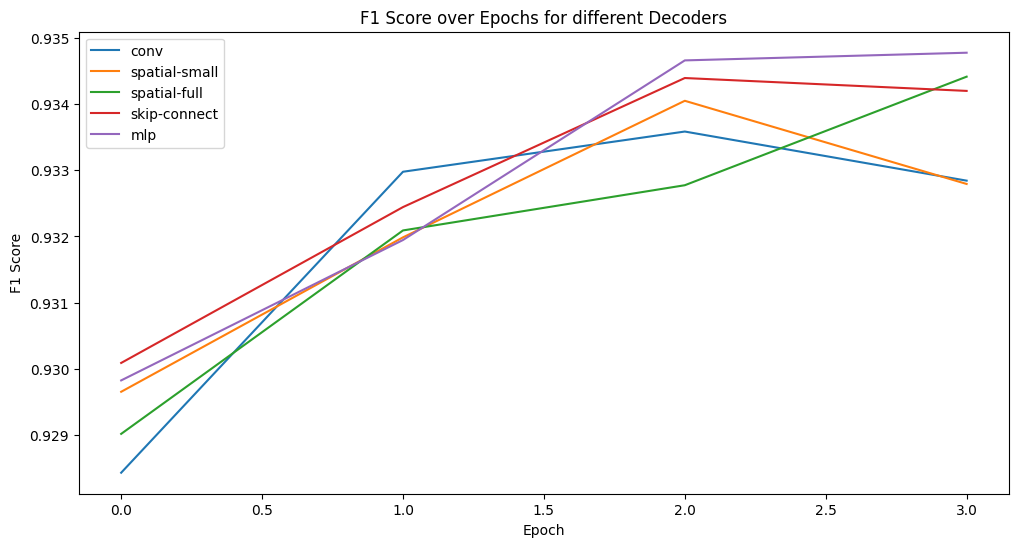

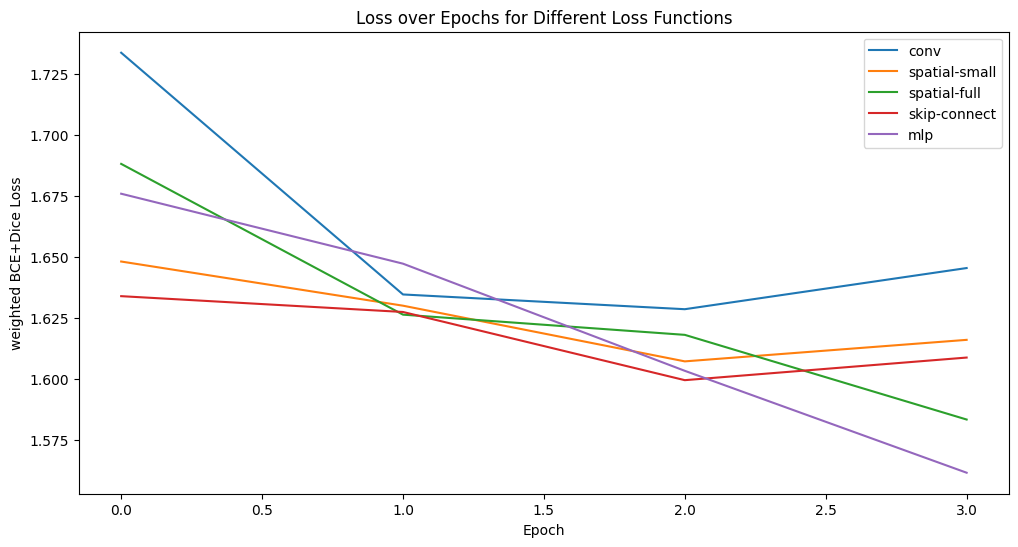

In [14]:
import matplotlib.pyplot as plt
epoch_sum = sum(epoch_ranges)
epochs = list(range(epoch_sum))

# Plot F1 Scores
plt.figure(figsize=(12, 6))
for decoder_option in decoder_options:
    plt.plot(epochs, f1_scores[decoder_option], label=decoder_option)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for different Decoders')
plt.legend()
plt.show()

# Plot Loss Scores
plt.figure(figsize=(12, 6))
for decoder_option in decoder_options:
    plt.plot(epochs, losses[decoder_option], label=decoder_option)
plt.xlabel('Epoch')
plt.ylabel('weighted BCE+Dice Loss')
plt.title('Loss over Epochs for Different Loss Functions')
plt.legend()
plt.show()

In [ ]:
assert False

# Figuring out the best finetuning strategy:

for this try out different learning rate and dataset options. Tune for at most 20 epochs, get the scores and validate them in the kaggle submission system

In [17]:
from tqdm import tqdm

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")


lr_options = [0.0001,0.00001]

training_options = [kaggle_train_dataloader,kaggle_epfl_train_dataloader]
test_options = [kaggle_test_dataloader,kaggle_epfl_test_dataloader]

training_desc = ["kaggle","kaggle_epfl"]

# now check only for the best model, the mlp model


max_epochs = 21

train_losses = {}
train_f1_scores = {}
test_losses = {}
test_f1_scores = {}

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)

for lr in lr_options:
    for train_idx in range(len(training_desc)):
        train_loader = training_options[train_idx]
        test_loader = test_options[train_idx]
        
        desc_key = f"lr_{lr}_{training_desc[train_idx]}"
        
        print("now doing: ",desc_key)
        
        train_losses[desc_key] = []
        train_f1_scores[desc_key] = []
        test_losses[desc_key] = []
        test_f1_scores[desc_key] = []
        
        model = load_sam_model("mlp",device,encoder_finetune_num_first_layers=25,encoder_finetune_num_last_layers=105,finetuned_model_name="model_3_mlp_decoder_finetune_last_25_105_epoch_3",sam_checkpoint_or_finetuned="finetuned",load_from_compiled=False)
        model = torch.compile(model)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(max_epochs):
            
            # TRAIN
            torch.cuda.empty_cache()
            gc.collect()
            
            model.train()
            optimizer.zero_grad()
            
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0
            step_counter = 0
            for img,mask in tqdm(train_loader):
                step_counter += 1
                img = img.to(device)
                mask = mask.to(device)
                pred = model(img)
                loss = loss_fn(pred,mask)
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                loss.backward()
                if step_counter % 5 == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # save the results: 
            train_losses[desc_key].append(epoch_running_loss/len(train_loader))
            train_f1_scores[desc_key].append(epoch_running_f1/len(train_loader))    
            
            # save the model at specific intervals: 
            if epoch % 5 == 0:
                model_path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/mlp_{desc_key}_epoch_{epoch}.pth"
                torch.save(model.state_dict(), model_path)
            
            # TEST
            
            model.eval()
            with torch.no_grad():
                epoch_running_loss = 0.0
                epoch_running_f1 = 0.0
                step_counter = 0
                for img,mask in tqdm(test_loader):
                    step_counter += 1
                    img = img.to(device)
                    mask = mask.to(device)
                    pred = model(img)
                    loss = loss_fn(pred,mask)
                    f1_score = mean_f1_score_from_logits(pred,mask).item()
                    epoch_running_loss += loss.item()
                    epoch_running_f1 += f1_score
                    
                # save the results: 
                test_losses[desc_key].append(epoch_running_loss/len(test_loader))
                test_f1_scores[desc_key].append(epoch_running_f1/len(test_loader))    


print("train losses:",train_losses)
print("train f1 scores:",train_f1_scores)
print("test losses:",test_losses)
print("test f1 scores:",test_f1_scores)

now doing:  lr_0.0001_kaggle
Percentage of trainable parameters:  0.7128846751631955


100%|██████████| 28/28 [00:02<00:00, 13.88it/s]


now doing:  lr_0.0001_kaggle_epfl
Percentage of trainable parameters:  0.7128846751631955


100%|██████████| 48/48 [00:03<00:00, 13.94it/s]


now doing:  lr_1e-05_kaggle
Percentage of trainable parameters:  0.7128846751631955


100%|██████████| 28/28 [00:02<00:00, 13.83it/s]


now doing:  lr_1e-05_kaggle_epfl
Percentage of trainable parameters:  0.7128846751631955


100%|██████████| 48/48 [00:03<00:00, 14.41it/s]

train losses: {'lr_0.0001_kaggle': [1.5612943013166558, 1.3262154349479183, 1.2324087085395024, 1.0926539587049648, 1.0343294002372643, 0.9889367826539894, 0.9490363248463335, 0.9189856198841128, 0.8650359290427175, 0.8348160699523729, 0.7983811732766957, 0.8027687784412811, 0.7458858640286429, 0.7230679202696373, 0.6868498795505228, 0.6511108674879732, 0.6207937238545254, 0.6247302748519798, 0.6199483868890795, 0.6277273617171008, 0.5724204746556694], 'lr_0.0001_kaggle_epfl': [1.5405410829247261, 1.2193917946851984, 1.1067409536668233, 1.0247424272250156, 0.9348842192973409, 0.9167790911635574, 0.8436281373914407, 0.826021742379787, 0.7598769876117609, 0.7202820488993003, 0.6932667590753765, 0.6661686006249213, 0.6785320157603342, 0.6066017961319612, 0.5999463129484531, 0.5868305124494494, 0.5640722521941881, 0.5676563655083277, 0.5473080452683629, 0.5118216421759251, 0.5030646763209786], 'lr_1e-05_kaggle': [1.5266482614237686, 1.4204783244379635, 1.3619245514273643, 1.331053807046906

In [18]:
# for each key in test_f1_scores; print the 0,5,10,15,20 epoch results

max_thing = (0,0)
max_val = 0.

for key in test_f1_scores.keys():
    print(f"key: {key}")
    idxs = [0,5,10,15,20]
    for idx in idxs:
        print(f"epoch: {idx}, loss: {test_losses[key][idx]}, f1: {test_f1_scores[key][idx]}")
        if test_f1_scores[key][idx] > max_val:
            max_val = test_f1_scores[key][idx]
            max_thing = (key,idx)
            
print("max thing:",max_thing, "max val:",max_val)

key: lr_0.0001_kaggle
epoch: 0, loss: 1.484860611813409, f1: 0.9371529987880162
epoch: 5, loss: 1.554891152041299, f1: 0.9379650524684361
epoch: 10, loss: 1.6568523858274733, f1: 0.9382744495357785
epoch: 15, loss: 1.7883760737521308, f1: 0.9353540646178382
epoch: 20, loss: 1.9119176055703844, f1: 0.9365625019584384
key: lr_0.0001_kaggle_epfl
epoch: 0, loss: 1.4020963882406552, f1: 0.9411311546961466
epoch: 5, loss: 1.3121593327571948, f1: 0.9483804913858572
epoch: 10, loss: 1.3600575905293226, f1: 0.9480554101367792
epoch: 15, loss: 1.4478859330217044, f1: 0.9480747431516647
epoch: 20, loss: 1.5427383662511904, f1: 0.9489250580469767
key: lr_1e-05_kaggle
epoch: 0, loss: 1.5499801422868456, f1: 0.9347283499581474
epoch: 5, loss: 1.4855969441788537, f1: 0.9390436240604946
epoch: 10, loss: 1.499415791460446, f1: 0.9379801728895732
epoch: 15, loss: 1.4815739084567343, f1: 0.940618206347738
epoch: 20, loss: 1.5966372319630213, f1: 0.9377339205571583
key: lr_1e-05_kaggle_epfl
epoch: 0, loss

For evaluation reasons I want to submit two model predictions to the kaggle submission system:

lr_0.0001_kaggle_epfl', 20: local F1: 94.89 -> Online 93.255
lr_1e-05_kaggle, 15, local F1: 94.06 -> Online: 93.253

Furthermore its also clear that the correlation with the epfl data is not so good. Since the spread in local and online F1 is much bigger.

In [22]:
path = "custom_segment_anything/model_checkpoints/finetuned_kaggle/mlp_lr_0.0001_kaggle_epfl_epoch_20"
model_mlp_1 = load_sam_model("mlp",device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)


path2 = "custom_segment_anything/model_checkpoints/finetuned_kaggle/mlp_lr_1e-05_kaggle_epoch_15"
model_mlp_2 = load_sam_model("mlp",device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path2,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)

#model_to_submission(model_mlp_1,submission_dataloader,submission_filename =  "mlp_lr_0.0001_kaggle_epfl_epoch_20_submission.csv")
model_to_submission(model_mlp_2,submission_dataloader,submission_filename =  "mlp_lr_1e-05_kaggle_epoch_15_submission.csv")

Percentage of trainable parameters:  0.010153446180800859
Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:18<00:00,  7.93it/s]


# Now I want to finetune each model with the kaggle data

The finetuning strategy will be

batch_size = 15
run for at most 15 epochs
store for each decoder option, the best achieving f1 and score model seperately.



In [25]:



### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = kaggle_train_dataloader
test_loader = kaggle_test_dataloader


########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 10
do_intermed_prints = False



#########

decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"]

max_epochs = 15

##################################
# TRAINING LOOP
################################

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)


for decoder_option in decoder_options:
    
    # load the current model: 
    load_compiled = (decoder_option != "mlp")
    model_description = f"model_3_{decoder_option}_decoder_finetune_last_25_105_epoch_3"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=25,encoder_finetune_num_last_layers=105,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=load_compiled)
    if not load_compiled:
        model = torch.compile(model)
    best_f1 = 0.
    best_loss = 1000.

    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(max_epochs):
    
        torch.cuda.empty_cache()
        gc.collect()

        # training run: 
        model.train()
        # reset the gradients: 
        optimizer.zero_grad()
        
        #########################################
        # TRAINING LOOP
        step_counter = 0
        for image, mask in tqdm(train_loader):
            step_counter += 1
            #####################
            # forward pass
            image = image.to(device)
            mask = mask.to(device)    
            pred = model(image)
            # compute loss and f1 score: 
            loss = loss_fn(pred,mask)
            loss.backward()
            

            ###############
            # backward pass
            if step_counter % 5 == 0:
                # compute the gradients
                # update the model weights
                optimizer.step()
                # reset the gradients
                optimizer.zero_grad()
        
        ####### EVALUATION
        
        
        # testing run: 
        model.eval()
        with torch.no_grad():
            l_acc = 0.0
            score_acc = 0.0
            for image,mask in tqdm(test_loader):
                image = image.to(device)
                mask = mask.to(device)
                pred = model(image)
                # compute loss and f1 score: 
                score = mean_f1_score_from_logits(pred,mask)    
                loss =  loss_fn(pred,mask)
                # update running loss and f1 score
                score_acc += score.item()
                l_acc  += loss.item()
                # store the loss and f1 score
                
            mean_f1 = score_acc/len(test_loader)
            mean_loss = l_acc/len(test_loader)
        
        save_model_description_f1  = f"decoder_{decoder_option}_bestf1.pth"
        save_model_description_loss = f"decoder_{decoder_option}_bestloss.pth"
        file_path = "custom_segment_anything/model_checkpoints/finetuned_kaggle/"
        
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            torch.save(model.state_dict(), file_path+save_model_description_f1)
            print("Decoder option:",decoder_option,"new best f1:",best_f1)
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(model.state_dict(), file_path+save_model_description_loss)
            print("Decoder option:",decoder_option,"new best loss:",best_loss)
            
        #########################################
        
    print("finished training for decoder option:",decoder_option)
    print("best f1:",best_f1, "best loss:",best_loss)    



Percentage of trainable parameters:  0.7128846751631955


100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


Decoder option: mlp new best f1: 0.9356346513543811
Decoder option: mlp new best loss: 1.5039696097373962


100%|██████████| 28/28 [00:02<00:00, 13.85it/s]


Decoder option: mlp new best f1: 0.9358102253505162
Decoder option: mlp new best loss: 1.497254301394735


100%|██████████| 28/28 [00:02<00:00, 13.74it/s]


Decoder option: mlp new best f1: 0.9378622940608433
Decoder option: mlp new best loss: 1.4851503095456533


100%|██████████| 28/28 [00:02<00:00, 13.85it/s]


Decoder option: mlp new best f1: 0.9382672650473458
Decoder option: mlp new best loss: 1.4581070244312286


100%|██████████| 28/28 [00:02<00:00, 13.69it/s]


Decoder option: mlp new best f1: 0.9384732246398926


100%|██████████| 28/28 [00:02<00:00, 13.69it/s]


Decoder option: mlp new best f1: 0.9396631653819766
Decoder option: mlp new best loss: 1.4403232016733714


100%|██████████| 28/28 [00:02<00:00, 13.64it/s]


Decoder option: mlp new best f1: 0.9406011423894337


100%|██████████| 28/28 [00:02<00:00, 13.67it/s]


finished training for decoder option: mlp
best f1: 0.9406011423894337 best loss: 1.4403232016733714
Percentage of trainable parameters:  0.710502399520313


100%|██████████| 28/28 [00:11<00:00,  2.52it/s]


Decoder option: conv new best f1: 0.935264989733696
Decoder option: conv new best loss: 1.5304924952132362


100%|██████████| 28/28 [00:02<00:00, 13.44it/s]


Decoder option: conv new best f1: 0.9369103589228222
Decoder option: conv new best loss: 1.5247386630092348


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Decoder option: conv new best f1: 0.9374858289957047
Decoder option: conv new best loss: 1.4888742480959212


100%|██████████| 28/28 [00:02<00:00, 13.66it/s]


Decoder option: conv new best f1: 0.9376737752131054


100%|██████████| 28/28 [00:02<00:00, 13.66it/s]


Decoder option: conv new best f1: 0.9378691358225686
Decoder option: conv new best loss: 1.4795398584433965


100%|██████████| 28/28 [00:01<00:00, 14.11it/s]


Decoder option: conv new best f1: 0.9385169595479965
Decoder option: conv new best loss: 1.464057662657329


100%|██████████| 28/28 [00:01<00:00, 14.16it/s]


Decoder option: conv new best f1: 0.9396575902189527
Decoder option: conv new best loss: 1.4578515184777123


100%|██████████| 28/28 [00:01<00:00, 14.14it/s]


Decoder option: conv new best f1: 0.94107914183821
Decoder option: conv new best loss: 1.443434430020196


100%|██████████| 28/28 [00:02<00:00, 13.30it/s]


finished training for decoder option: conv
best f1: 0.94107914183821 best loss: 1.443434430020196
Percentage of trainable parameters:  0.7145367753246534


100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Decoder option: spatial-small new best f1: 0.9357218103749412
Decoder option: spatial-small new best loss: 1.5324673801660538


100%|██████████| 28/28 [00:02<00:00, 13.78it/s]


Decoder option: spatial-small new best f1: 0.9372733682394028
Decoder option: spatial-small new best loss: 1.499355239527566


100%|██████████| 28/28 [00:02<00:00, 13.58it/s]


Decoder option: spatial-small new best f1: 0.9378336838313511
Decoder option: spatial-small new best loss: 1.4787456723196166


100%|██████████| 28/28 [00:02<00:00, 13.63it/s]


Decoder option: spatial-small new best f1: 0.9389782611812864
Decoder option: spatial-small new best loss: 1.4749739553247179


100%|██████████| 28/28 [00:02<00:00, 13.71it/s]


Decoder option: spatial-small new best f1: 0.9398293537752969


100%|██████████| 28/28 [00:01<00:00, 14.10it/s]


Decoder option: spatial-small new best f1: 0.9401421227625438
finished training for decoder option: spatial-small
best f1: 0.9401421227625438 best loss: 1.4749739553247179
Percentage of trainable parameters:  0.7161699714498025


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Decoder option: spatial-full new best f1: 0.9347485495465142
Decoder option: spatial-full new best loss: 1.5649823929582323


100%|██████████| 28/28 [00:02<00:00, 13.76it/s]


Decoder option: spatial-full new best f1: 0.9362813085317612
Decoder option: spatial-full new best loss: 1.50843945145607


100%|██████████| 28/28 [00:02<00:00, 13.59it/s]


Decoder option: spatial-full new best f1: 0.9368414176361901
Decoder option: spatial-full new best loss: 1.4885620453527995


100%|██████████| 28/28 [00:02<00:00, 13.63it/s]


Decoder option: spatial-full new best f1: 0.9373072194201606
Decoder option: spatial-full new best loss: 1.4788245835474558


100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


Decoder option: spatial-full new best f1: 0.9378761265959058
Decoder option: spatial-full new best loss: 1.4782710586275374


100%|██████████| 28/28 [00:02<00:00, 13.21it/s]


Decoder option: spatial-full new best f1: 0.9394260900361198
Decoder option: spatial-full new best loss: 1.432130630527224


100%|██████████| 28/28 [00:02<00:00, 13.82it/s]


Decoder option: spatial-full new best f1: 0.9397370879139219


100%|██████████| 28/28 [00:02<00:00, 13.78it/s]


Decoder option: spatial-full new best f1: 0.9409123829432896


100%|██████████| 28/28 [00:02<00:00, 13.86it/s]


finished training for decoder option: spatial-full
best f1: 0.9409123829432896 best loss: 1.432130630527224
Percentage of trainable parameters:  0.7165753546940119


100%|██████████| 28/28 [00:11<00:00,  2.47it/s]


Decoder option: skip-connect new best f1: 0.934288603918893
Decoder option: skip-connect new best loss: 1.5476367899349757


100%|██████████| 28/28 [00:02<00:00, 13.65it/s]


Decoder option: skip-connect new best f1: 0.9364989506346839
Decoder option: skip-connect new best loss: 1.5103991776704788


100%|██████████| 28/28 [00:02<00:00, 13.96it/s]


Decoder option: skip-connect new best f1: 0.9385119804314205
Decoder option: skip-connect new best loss: 1.4747510020221983


100%|██████████| 28/28 [00:02<00:00, 13.91it/s]


Decoder option: skip-connect new best loss: 1.4691317358187266


100%|██████████| 28/28 [00:02<00:00, 13.93it/s]


Decoder option: skip-connect new best f1: 0.938564847622599
Decoder option: skip-connect new best loss: 1.465767261173044


100%|██████████| 28/28 [00:02<00:00, 13.90it/s]


Decoder option: skip-connect new best f1: 0.9389953655855996
Decoder option: skip-connect new best loss: 1.4468461136732782


100%|██████████| 28/28 [00:01<00:00, 14.13it/s]


Decoder option: skip-connect new best f1: 0.9390430450439453


100%|██████████| 28/28 [00:01<00:00, 14.02it/s]


Decoder option: skip-connect new best f1: 0.9407457964760917
Decoder option: skip-connect new best loss: 1.4466931287731444


100%|██████████| 28/28 [00:02<00:00, 13.81it/s]

finished training for decoder option: skip-connect
best f1: 0.9407457964760917 best loss: 1.4466931287731444


finished training for decoder option: mlp
best f1: 0.9406011423894337 best loss: 1.4403232016733714

finished training for decoder option: conv
best f1: 0.94107914183821 best loss: 1.443434430020196

finished training for decoder option: spatial-small
best f1: 0.9401421227625438 best loss: 1.4749739553247179

finished training for decoder option: spatial-full
best f1: 0.9409123829432896 best loss: 1.432130630527224

finished training for decoder option: skip-connect
best f1: 0.9407457964760917 best loss: 1.4466931287731444

# Single Model Submission and Rounding Ensemble Submission of best models

In [74]:

import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)


def ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    all_predictions = []
    for model in model_list:
        model = model.to(device)
        model.eval()
        predictions = []

        with torch.no_grad():
            for image in tqdm(submission_dataloader):
                image = image.to(device)
                pred = model(image)
                predictions.append(pred)
        model = model.to("cpu")
    # check the shape of the predictions
        assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
        all_predictions.append(predictions)
    # go over all predictions and convert the logits to predictions:
    
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    num_models = len(model_list)
    num_images = len(all_predictions[0])
    assert num_images == 144
    
    for img_index in range(num_images):
        
        
        ensemble_image = np.zeros((400,400))
        
        for model_idx in range(num_models):
            pred = all_predictions[model_idx][img_index]
            pred = pred.squeeze()
            # pred is torch vector of shape (1024,1024)
            # convert to image
            pred = torch.round(torch.sigmoid(pred))
            # compress to 400x400
            pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
            #print(pred.shape)
            # pred is now torch vector of shape (1,1,400,400)
            # convert to numpy
            pred = pred.squeeze().squeeze().to("cpu").numpy()
            #print(pred.shape)
            # pred is now numpy vector of shape (400,400)

            # add to initial image
            ensemble_image += pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        if rounding_policy == "up" or rounding_policy == "down":
            ensemble_image = ensemble_image/num_models
        
            # round the image
            if rounding_policy == "up":
                ensemble_image = np.round(ensemble_image)
            elif rounding_policy == "down":
                ensemble_image = np.floor(ensemble_image)
            else:
                raise ValueError("invalid rounding policy")
        elif rounding_policy == "min1":
            ensemble_image[ensemble_image > 1] = 1
            #ensemble_image = np.round(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        # store as png to disk
        ensemble_image = (ensemble_image * 255).astype(np.uint8)
        # add 2 other color channels
        ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold=foreground_threshold)
    
    
    
def ensemble_model_loss_f1(model_list,test_dataloader,rounding_policy="up",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    for model in model_list:
        model = model.to(device)
        model.eval()

    num_models = len(model_list)
    f1_acc = 0.
    
    for image, mask in tqdm(test_dataloader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        ensemble_image = torch.zeros((1,1,1024,1024),device=device)
        
        with torch.no_grad():
            for model in model_list:
                pred = model(image)
                pred = torch.round(torch.sigmoid(pred))
                ensemble_image = ensemble_image + pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        if rounding_policy == "up" or rounding_policy == "down":
            ensemble_image = ensemble_image/num_models
        
            # round the image
            if rounding_policy == "up":
                ensemble_image = torch.round(ensemble_image)
            elif rounding_policy == "down":
                ensemble_image = torch.floor(ensemble_image)
            else:
                raise ValueError("invalid rounding policy")
        elif rounding_policy == "min1":
            ensemble_image[ensemble_image > 1] = 1
            #ensemble_image = np.round(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        
        # compute the f1 score here: 
        
      
        # compute the f1 score
        f1_acc += mean_f1_score_from_classes(ensemble_image,mask)
        
    print("mean f1_score: ",f1_acc/len(test_dataloader))

# Computing F1 - Score on Kaggle Test split of Majority Vote MLP BiSeSam

In [75]:
ensemble_model_loss_f1(model_list,kaggle_test_dataloader,rounding_policy="up",foreground_threshold=0.25)

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]

mean f1_score:  tensor(0.9419, device='cuda:0')


# Creating Submission for the decoders

In [26]:
decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"]

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_to_submission(model,submission_dataloader,submission_filename =  f"decoder_{decoder_option}_submission.csv")

Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:17<00:00,  8.12it/s]


Percentage of trainable parameters:  0.0019404142338121852


100%|██████████| 144/144 [00:17<00:00,  8.19it/s]


Percentage of trainable parameters:  0.01584915626633101


100%|██████████| 144/144 [00:19<00:00,  7.51it/s]


Percentage of trainable parameters:  0.02147969360218568


100%|██████████| 144/144 [00:19<00:00,  7.48it/s]


Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:18<00:00,  7.76it/s]


In [28]:
# create a majority vote ensemble of the models
model_list = []

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_list.append(model)

ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "majority_vote_ensemble_submission.csv",foreground_threshold=0.25)

Percentage of trainable parameters:  0.010153446180800859
Percentage of trainable parameters:  0.0019404142338121852
Percentage of trainable parameters:  0.01584915626633101
Percentage of trainable parameters:  0.02147969360218568
Percentage of trainable parameters:  0.022877275592923414


100%|██████████| 144/144 [00:17<00:00,  8.32it/s]


In [ ]:
# TODO compute the majority vote mlp ensemble score on the current f1 test set split. 

# Training an Ensemble of N models

The idea is to concatenate the logit predicitions of all models together, use the sigmoid on them and then feed this information into an mlp, and train this for 1 epoch. This then is the final mlp prediction.:

Please note that the trained ensemble model is extremely specific to the models that were used to train it.

In [29]:


# now we test these models submission:

# create a majority vote ensemble of the models
decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"] # IMPORTANT IS THE CORRECT ORDER FOR ENSEMBLE TRAIN COMPUTATION/LOADING FROM MEMORY
model_list = []

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_list.append(model)


Percentage of trainable parameters:  0.010153446180800859
Percentage of trainable parameters:  0.0019404142338121852
Percentage of trainable parameters:  0.01584915626633101
Percentage of trainable parameters:  0.02147969360218568
Percentage of trainable parameters:  0.022877275592923414


In [40]:
from tqdm import tqdm
num_models = len(model_list)

######## DEFINE MODEL ########
from custom_segment_anything.segment_anything.CUSTOM_SAM import EnsembleMLP

#gc
import gc
gc.collect()
torch.cuda.empty_cache()
# enable TF32
torch.set_float32_matmul_precision("high")


ensemble_model = EnsembleMLP(num_models)

######### OPTIMIZER AND LOSS FUNCTION ########
loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.0001)

max_num_epochs=10
####### DATA LOADER ##########
train_loader = kaggle_train_dataloader
eval_d_loader = kaggle_test_dataloader


# bring all models to the device

for model in model_list:
    model = model.to(device)

ensemble_model = ensemble_model.to(device)
##############################


for epoch_counter in range(max_num_epochs):

    # go over all models and feed the input image: 

    ensemble_model.train()
    
    ###### TRAINING: #######
    loss_acc = 0.0
    f1_acc = 0.0
    
    step_counter = 0

    for image, mask in tqdm(train_loader):

        image = image.to(device)
        mask = mask.to(device)
        all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(num_models):
                model = model_list[model_idx]

                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
        
        # compute the ensemble prediction
        ensemble_pred = ensemble_model(all_preds).squeeze(4)
        # compute the loss
        #print(ensemble_pred.shape,mask.shape,ensemble_pred.min(),ensemble_pred.max(),mask.min(),mask.max())
        loss = loss_fn(ensemble_pred,mask)
        # backpropagate
        loss.backward()
        optimizer.step()
        loss_acc += loss.item()
        # compute the f1 score
        f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()

    # print the loss and f1 score
    print(f"Epoch {epoch_counter} (train) Loss: {loss_acc/len(train_loader)}, F1-Score: {f1_acc/len(train_loader)}")
     
        

    torch.save(ensemble_model.state_dict(), f"custom_segment_anything/model_checkpoints/ensemble_mlp/ensemble_model_{epoch_counter}.pth")
    
    ###### TESTING: #######
        
    ensemble_model.eval()
    loss_acc = 0.
    f1_acc = 0.
    for image, mask in tqdm(eval_d_loader):
        image = image.to(device)
        mask = mask.to(device)
        all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(num_models):
                model = model_list[model_idx]
                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
        
            # compute the ensemble prediction
            ensemble_pred = ensemble_model(all_preds).squeeze(4)
            # compute the loss

            loss = loss_fn(ensemble_pred,mask)
            loss_acc += loss.item()
            # compute the f1 score
            f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()

    # print the loss and f1 score
    print(f"Epoch {epoch_counter} (test) Loss: {loss_acc/len(eval_d_loader)}, F1-Score: {f1_acc/len(eval_d_loader)}")
    

    



  0%|          | 0/116 [00:00<?, ?it/s]

100%|██████████| 116/116 [00:38<00:00,  2.98it/s]


Epoch 0 (train) Loss: 5.612842428273168, F1-Score: 0.833854314068268


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Epoch 0 (test) Loss: 4.956784571920123, F1-Score: 0.9386676060301917


100%|██████████| 116/116 [00:39<00:00,  2.95it/s]


Epoch 1 (train) Loss: 4.200724513366304, F1-Score: 0.9462775690802212


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Epoch 1 (test) Loss: 3.402074021952493, F1-Score: 0.9424028737204415


100%|██████████| 116/116 [00:39<00:00,  2.96it/s]


Epoch 2 (train) Loss: 2.6107470064327636, F1-Score: 0.956580024341057


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Epoch 2 (test) Loss: 2.0874728049550737, F1-Score: 0.9427699340241296


100%|██████████| 116/116 [00:38<00:00,  3.00it/s]


Epoch 3 (train) Loss: 1.562098798566851, F1-Score: 0.9566172387065559


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Epoch 3 (test) Loss: 1.5704678275755473, F1-Score: 0.9428737844739642


100%|██████████| 116/116 [00:39<00:00,  2.95it/s]


Epoch 4 (train) Loss: 1.2312346892110233, F1-Score: 0.9567571934954874


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Epoch 4 (test) Loss: 1.6709775562797273, F1-Score: 0.9425520577601024


100%|██████████| 116/116 [00:38<00:00,  3.00it/s]


Epoch 5 (train) Loss: 1.2830155669101353, F1-Score: 0.9570961800114862


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Epoch 5 (test) Loss: 1.9716985151171684, F1-Score: 0.9423187396356038


100%|██████████| 116/116 [00:38<00:00,  2.99it/s]


Epoch 6 (train) Loss: 1.4530143532259712, F1-Score: 0.957047181910482


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Epoch 6 (test) Loss: 2.201934613287449, F1-Score: 0.9433199678148542


100%|██████████| 116/116 [00:38<00:00,  2.99it/s]


Epoch 7 (train) Loss: 1.6016151064942623, F1-Score: 0.9569735367750299


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Epoch 7 (test) Loss: 2.430547815348421, F1-Score: 0.9427204110792705


100%|██████████| 116/116 [00:39<00:00,  2.96it/s]


Epoch 8 (train) Loss: 1.6847043497295215, F1-Score: 0.9571727724938557


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Epoch 8 (test) Loss: 2.6072530948690007, F1-Score: 0.9415894619056157


100%|██████████| 116/116 [00:38<00:00,  3.02it/s]


Epoch 9 (train) Loss: 1.7160576710413242, F1-Score: 0.9569376912610285


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]

Epoch 9 (test) Loss: 2.6013791135379245, F1-Score: 0.9412111235516412


# Now creating a submission with this trained ensemble model

In [36]:

# epoche or 3 or 9? 

num_models = len(model_list)
ensemble_model = EnsembleMLP(num_models)
ensemble_model.load_state_dict(torch.load("custom_segment_anything/model_checkpoints/ensemble_mlp/ensemble_model_9.pth"))

ensemble_model = ensemble_model.to(device)

# do prediction using ensemble model: 
# use sigmoid and then round

In [37]:
from tqdm import tqdm
from mask_to_submission import make_submission
def trained_ensemble_models_to_submission(ensemble_model,model_list,submission_dataloader,submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert pass these logits to the ensemble model and then convert them to predictions using sigmoid and rounding
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # first compute all predictions with the model
    counter = 144
    
    for image in tqdm(submission_dataloader):
        image = image.to(device)    
        all_preds = torch.zeros((1,1,1024,1024,len(model_list))).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(len(model_list)):
                model = model_list[model_idx]
                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
            # compute the ensemble prediction
            ensemble_pred = ensemble_model(all_preds).squeeze(4)
            # convert to numpy
            #ensemble_pred = ensemble_pred
            
            # round the image
            ensemble_image = torch.round(torch.sigmoid(ensemble_pred))
            #print(ensemble_image.shape)
            #print("HELLO")
            ensemble_image = F.interpolate(ensemble_image, size=(400,400), mode='nearest')
            ensemble_image = ensemble_image.squeeze().squeeze().to("cpu").numpy()
            #print(ensemble_image.shape)
            # pred is now numpy vector of shape (400,400)

   
        
        
        
            # store as png to disk
            ensemble_image = (ensemble_image * 255).astype(np.uint8)
            # add 2 other color channels
            ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
            #print(pred.shape)
            # save to disk
            plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
            counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold= foreground_threshold)


In [39]:
trained_ensemble_models_to_submission(ensemble_model,model_list,submission_dataloader,submission_filename =  "mlp_ensemble_9.csv", foreground_threshold=0.25)

100%|██████████| 144/144 [00:48<00:00,  2.99it/s]


Another ensemble with min 1 policy, its street, if at least one model says street;



In [ ]:
ensemble_models_to_submission(ensemble_model_list,submission_dataloader,rounding_policy="min1",submission_filename =  "ensemble_submission_top7_loss_min1_rounding.csv",foreground_threshold=0.25)

In [31]:
base = 0.86517
ours = 0.92984
best = 0.93628
grade = 4 + 2 * (ours - base)/(best - base)

print("our grade:",grade)


our grade: 5.818872169877654
